In [1]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import statistics
import sys
import os

In [2]:
def batch_gen():
    with open(file_path) as f:
        for index, line in enumerate(f):
            yield index, line

In [3]:
def correct_timestep(ti):
    new_ti = list()
    for i in range(0, len(ti)):
        new_ti.append(ti[i] - (9*i))
    return new_ti

In [4]:
def min_ip(inflection_points):
    remove_list = list()
    for ip in range(0, len(inflection_points)):
        if inflection_points[ip] < 0:
            remove_list.append(ip)
    if not remove_list:
        ip_pos = inflection_points
    else:
        remove_arr = np.asarray(remove_list)
        ip_pos = np.delete(inflection_points, remove_arr)
    return min(ip_pos)

In [5]:
def find_values(x_data, ip):
    index = (np.abs(x_data-ip)).argmin()
    return np.unique(x_data[index])

In [6]:
def find_index(x_data, ip):
    index = (np.abs(x_data-ip)).argmin()
    return index

In [7]:
def make_array(array):
    new_list = list()
    for arr_sel in range(0, len(array)):
        new_list.append(array[arr_sel])
    new_arr = np.asarray(new_list)
    return new_arr

In [8]:
def return_slope(x, y):
    m = (((statistics.mean(x)*statistics.mean(y)) - statistics.mean(x*y))/((statistics.mean(x)*statistics.mean(x)) - statistics.mean(x*x)))
    return m

In [9]:
def temp_gen():
    for i in range(0, 8):
        for temp in temp_bin_arr[:, i]:
            yield temp

In [10]:
def pos_gen():
    for i in range(0, 8):
        for x in x_bin_arr[:, i]:
            yield x

In [11]:
def exponential(x_data, a, b, c):
    return a*np.exp(x_data*b) + c

In [12]:
def solve_x_exp(parameters, y):
    return (np.log((y - parameters[2])/parameters[0]))/parameters[1]

In [13]:
while True:
    try:
        n_bins = int(input('Enter number of bins: '))
    except ValueError:
        print('Enter a positive whole number')
    if n_bins <= 0:
        print('Enter a positive whole number')
        continue
    else:
        break

Enter number of bins: 250


In [14]:
folder_path = r'C:/Users/krist/Research/50-50'
file = 'dump.baras_reaction_16.1nm_1.34'
file_path = os.path.join(folder_path, file)

In [15]:
timestep_index = list()
x_data = list()
y_data = list()
z_data = list()
c_ke = list()
skip = 0
x = 0

instance = batch_gen()
while True:
    try:
        content = [next(instance) for i in range(0, 100)]
    except:
        break
    for line in range(0, len(content)):
        if skip != 0:
            skip = skip - 1
            continue
        if 'TIMESTEP' in str(content[line][1]):
            timestep_index.append(content[line][0])
            skip = 1
            continue
        elif 'NUMBER OF ATOMS' in str(content[line][1]):
            skip = 1
            continue
        elif 'BOX BOUNDS' in str(content[line][1]):
            skip = 3
            continue
        elif 'ITEM: ATOMS' in str(content[line][1]):
            continue
        else:
            data_strip = content[line][1].strip('\n')
            cat_split = data_strip.split()
            x_data.append(float(cat_split[2]))
            #y_data.append(float(cat_split[3]))
            #z_data.append(float(cat_split[4]))
            c_ke.append(float(cat_split[5]))
            content.append(data_strip)

In [16]:
correct_ti = correct_timestep(timestep_index)

In [17]:
min_x = list()
max_x = list()
for i in range(0, len(correct_ti)):
    if i == len(correct_ti) - 1:
        min_x.append(min(x_data[correct_ti[i]:]))
        max_x.append(max(x_data[correct_ti[i]:]))
    else:
        min_x.append(min(x_data[correct_ti[i]:correct_ti[i+1]]))
        max_x.append(max(x_data[correct_ti[i]:correct_ti[i+1]]))

In [18]:
x_arr = np.asarray(x_data)
temp_arr = np.asarray(c_ke)
data_arr = np.column_stack((x_arr, c_ke))

In [19]:
x_bin_arr = np.zeros((n_bins, 8), dtype = float)
temp_bin_arr = np.zeros((n_bins, 8), dtype = float)
final_values = list()
x_select_list = list()
temp_select_list = list()
time = list()
row = -1

for i in range(5, 20, 2): #len(correct_ti)):  or range(5, 20, 2)
    row = row + 1
    time.append(i*0.2)
    total_length = max_x[i] - min_x[i]
    bin_length = total_length/n_bins
    correct_data_arr = data_arr[correct_ti[i]:correct_ti[i+1]]
    data_sort_arr = correct_data_arr[correct_data_arr[:, 0].argsort()]
    for binning in range(0, n_bins):
        high = find_index(data_sort_arr[:, 0], (binning + 1)*bin_length + min_x[i])
        low = find_index(data_sort_arr[:, 0], (binning*bin_length) + min_x[i])
        for select_points in data_sort_arr[low:high]:
            x_select_list.append(select_points[0])
            temp_select_list.append(select_points[1])
        
        avg_x = statistics.mean(x_select_list)
        avg_temp = statistics.mean(temp_select_list)
        x_bin_arr[binning, row] = avg_x
        temp_bin_arr[binning, row] = avg_temp
        x_select_list.clear()
        temp_select_list.clear()

time_arr = np.asarray(time)

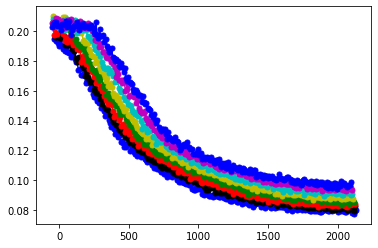

In [20]:
for plot_row in range(0, 8):
    plt.plot(x_bin_arr[:, plot_row], temp_bin_arr[:, plot_row], marker = 'o', ms = 5, color = "bkrgycmbkrgycmbkrgycm"[plot_row])

In [27]:
test_arr = np.zeros((150, 6), dtype = float)
prev_x = np.full(150, 400)
#chosen_temps = [900, 950, 1000, 1050, 1100, 1150, 1200] #[800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800]
chosen_temps = [x for x in range(900, 1200, 2)]
possible_choices = list()
instance2 = temp_gen()
instance3 = pos_gen()
next(instance2)
next(instance3)

for col_sel in range(0, 6):  # Change 8 to input (along with initialization for temp_bin_arr and x_bin_arr)
    print('START {}'.format(col_sel))
    for start in range(0, len(temp_bin_arr[:, col_sel])):
        coefs = np.polyfit(x_bin_arr[:, col_sel], temp_bin_arr[:, col_sel], 4)
        x_bin_arr_fit = np.linspace(x_bin_arr[0, col_sel], x_bin_arr[-1, col_sel], len(x_bin_arr[:, col_sel]))
        ffit = np.polyval(coefs, x_bin_arr_fit)
        #plt.plot(x_bin_arr_fit, ffit)
        #plt.ylim(0.075, 0.275)
        #plt.xlim(0, 4276.8)
    for row_sel in range(0, len(chosen_temps)):
        curr_temp = (chosen_temps[row_sel]/11604.5250061657)*(3/2)
        curr_pos = (np.polynomial.Polynomial.fit(x_bin_arr[:, col_sel], temp_bin_arr[:, col_sel], 4) - curr_temp).roots()
        real_values = abs(curr_pos.real[abs(curr_pos.imag) < 1e-5])
        print(real_values)
        if len(real_values) == 1:
            prev_x[row_sel] = real_values
            continue
        if len(real_values) <= 0:
            print('no real solutions')
        if len(real_values) > 1:
            for i in real_values:
                if abs(i) > 2851.2:
                    print('loop 1')
                    real_values = np.delete(real_values, np.where(real_values == i))
                    print(real_values)
        if len(real_values) > 1:
            print('loop 2')
            print(prev_x[row_sel])
            real_values = real_values[np.where(np.logical_and(real_values >= prev_x[row_sel], real_values <= 1700))]
            print('HOLD UP {}'.format(real_values))
            #if len(real_values) == 1:
            #    prev_x = real_values
            #if len(real_values) > 1:
            #    real_values = real_values[np.where(real_values > prev_x)]
            if len(real_values) > 1:
                real_values = real_values[real_values.argmin()]
                prev_x[row_sel] = real_values
                print(real_values)
                print(prev_x)
            if real_values.size == 1:
                prev_x[row_sel] = real_values
                print(real_values)
                print(prev_x)
        test_arr[row_sel, col_sel] = real_values

START 0
[  601.72640637 27062.8080957 ]
loop 1
[601.72640637]
[  598.60964534 27062.83003093]
loop 1
[598.60964534]
[  595.50906392 27062.85196604]
loop 1
[595.50906392]
[  592.42445865 27062.87390105]
loop 1
[592.42445865]
[  589.35563008 27062.89583593]
loop 1
[589.35563008]
[  586.30238268 27062.91777071]
loop 1
[586.30238268]
[  583.26452476 27062.93970537]
loop 1
[583.26452476]
[  580.24186832 27062.96163991]
loop 1
[580.24186832]
[  577.23422899 27062.98357435]
loop 1
[577.23422899]
[  574.24142593 27063.00550867]
loop 1
[574.24142593]
[  571.26328173 27063.02744287]
loop 1
[571.26328173]
[  568.2996223  27063.04937696]
loop 1
[568.2996223]
[  565.35027684 27063.07131094]
loop 1
[565.35027684]
[  562.4150777 27063.0932448]
loop 1
[562.4150777]
[  559.49386035 27063.11517855]
loop 1
[559.49386035]
[  556.58646326 27063.13711218]
loop 1
[556.58646326]
[  553.69272785 27063.1590457 ]
loop 1
[553.69272785]
[  550.81249839 27063.18097911]
loop 1
[550.81249839]
[  547.94562197 27063.20

[  530.99034648 16550.52385132]
loop 1
[530.99034648]
[  528.23948975 16550.59286297]
loop 1
[528.23948975]
[  525.50040433 16550.66187271]
loop 1
[525.50040433]
[  522.77296965 16550.73088051]
loop 1
[522.77296965]
[  520.05706708 16550.79988639]
loop 1
[520.05706708]
[  517.35257986 16550.86889035]
loop 1
[517.35257986]
[  514.65939312 16550.93789238]
loop 1
[514.65939312]
[  511.97739379 16551.00689248]
loop 1
[511.97739379]
[  509.30647056 16551.07589066]
loop 1
[509.30647056]
[  506.6465139  16551.14488692]
loop 1
[506.6465139]
[  503.99741594 16551.21388125]
loop 1
[503.99741594]
[  501.3590705  16551.28287366]
loop 1
[501.3590705]
[  498.73137303 16551.35186414]
loop 1
[498.73137303]
[  496.11422056 16551.4208527 ]
loop 1
[496.11422056]
[  493.50751171 16551.48983933]
loop 1
[493.50751171]
[  490.91114661 16551.55882405]
loop 1
[490.91114661]
[  488.32502691 16551.62780683]
loop 1
[488.32502691]
[  485.7490557  16551.69678769]
loop 1
[485.7490557]
[  483.18313755 16551.76576663]

loop 1
[384.72091348]
[5239.95365218  382.53144564]
loop 1
[382.53144564]
[5239.76214994  380.34760991]
loop 1
[380.34760991]
[5239.57061577  378.16936657]
loop 1
[378.16936657]
[5239.37904965  375.99667632]
loop 1
[375.99667632]
[5239.18745158  373.8295003 ]
loop 1
[373.8295003]
[5238.99582153  371.66780011]
loop 1
[371.66780011]
[5238.80415949  369.51153774]
loop 1
[369.51153774]
[5238.61246545  367.36067561]
loop 1
[367.36067561]
[5238.4207394   365.21517654]
loop 1
[365.21517654]
[5238.22898132  363.07500377]
loop 1
[363.07500377]
[5238.0371912   360.94012093]
loop 1
[360.94012093]
[5237.84536903  358.81049204]
loop 1
[358.81049204]
[5237.65351479  356.68608152]
loop 1
[356.68608152]
[5237.46162847  354.56685414]
loop 1
[354.56685414]
[5237.26971006  352.45277508]
loop 1
[352.45277508]
[5237.07775953  350.34380987]
loop 1
[350.34380987]
[5236.88577689  348.23992442]
loop 1
[348.23992442]
[5236.69376211  346.14108498]
loop 1
[346.14108498]
[5236.50171519  344.04725816]
loop 1
[344.0

[1656.22241983  831.22110037]
loop 2
400
HOLD UP [1656.22241983  831.22110037]
831.2211003716878
[838 834 831 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400]
831.2211003716878
[838 834 831 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400

 400 400 400 400 400 400]
[1620.77499923  614.74421839]
loop 2
400
HOLD UP [1620.77499923  614.74421839]
614.7442183934438
[838 834 831 827 824 820 816 813 809 806 802 799 796 792 789 785 782 779
 775 772 769 766 762 759 756 753 749 746 743 740 737 734 731 728 725 722
 718 715 712 709 706 704 701 698 695 692 689 686 683 680 677 674 672 669
 666 663 660 658 655 652 649 647 644 641 638 636 633 630 628 625 622 620
 617 614 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400]
614.7442183934438
[838 834 831 827 824 820 816 813 809 806 802 799 796 792 789 785 782 779
 775 772 769 766 762 759 756 753 749 746 743 740 737 734 731 728 725 722
 718 715 712 709 706 704 701 698 695 692 689 686 683 680 677 674 672 669
 666 663 660 658 655 652 649 6

[1588.81736888  468.9951096 ]
loop 2
400
HOLD UP [1588.81736888  468.9951096 ]
468.9951096036606
[838 834 831 827 824 820 816 813 809 806 802 799 796 792 789 785 782 779
 775 772 769 766 762 759 756 753 749 746 743 740 737 734 731 728 725 722
 718 715 712 709 706 704 701 698 695 692 689 686 683 680 677 674 672 669
 666 663 660 658 655 652 649 647 644 641 638 636 633 630 628 625 622 620
 617 614 612 609 606 604 601 599 596 593 591 588 586 583 581 578 576 573
 571 568 566 563 561 558 556 553 551 548 546 543 541 539 536 534 531 529
 527 524 522 519 517 515 512 510 508 505 503 501 498 496 494 491 489 487
 484 482 480 478 475 473 471 468 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400]
468.9951096036606
[838 834 831 827 824 820 816 813 809 806 802 799 796 792 789 785 782 779
 775 772 769 766 762 759 756 753 749 746 743 740 737 734 731 728 725 722
 718 715 712 709 706 704 701 698 695 692 689 686 683 680 677 674 672 669
 666 663 660 658 655 652 649 647 644 641 638 636 633 630

 444 442 440 437 435 433]
[886.85839392 845.68503257]
loop 2
785
HOLD UP [886.85839392 845.68503257]
845.6850325714892
[895 893 889 886 882 879 875 872 868 865 862 858 855 852 848 845 782 779
 775 772 769 766 762 759 756 753 749 746 743 740 737 734 731 728 725 722
 718 715 712 709 706 704 701 698 695 692 689 686 683 680 677 674 672 669
 666 663 660 658 655 652 649 647 644 641 638 636 633 630 628 625 622 620
 617 614 612 609 606 604 601 599 596 593 591 588 586 583 581 578 576 573
 571 568 566 563 561 558 556 553 551 548 546 543 541 539 536 534 531 529
 527 524 522 519 517 515 512 510 508 505 503 501 498 496 494 491 489 487
 484 482 480 478 475 473 471 468 466 464 462 459 457 455 453 451 448 446
 444 442 440 437 435 433]
845.6850325714892
[895 893 889 886 882 879 875 872 868 865 862 858 855 852 848 845 782 779
 775 772 769 766 762 759 756 753 749 746 743 740 737 734 731 728 725 722
 718 715 712 709 706 704 701 698 695 692 689 686 683 680 677 674 672 669
 666 663 660 658 655 652 649 647 6

 444 442 440 437 435 433]
[849.22674659 676.40596825]
loop 2
612
HOLD UP [849.22674659 676.40596825]
676.4059682519462
[895 893 889 886 882 879 875 872 868 865 862 858 855 852 848 845 842 839
 835 832 829 826 823 820 817 813 810 807 804 801 798 795 792 789 786 783
 780 777 774 771 769 766 763 760 757 754 751 749 746 743 740 737 735 732
 729 726 724 721 718 715 713 710 707 705 702 699 697 694 692 689 686 684
 681 678 676 609 606 604 601 599 596 593 591 588 586 583 581 578 576 573
 571 568 566 563 561 558 556 553 551 548 546 543 541 539 536 534 531 529
 527 524 522 519 517 515 512 510 508 505 503 501 498 496 494 491 489 487
 484 482 480 478 475 473 471 468 466 464 462 459 457 455 453 451 448 446
 444 442 440 437 435 433]
676.4059682519462
[895 893 889 886 882 879 875 872 868 865 862 858 855 852 848 845 842 839
 835 832 829 826 823 820 817 813 810 807 804 801 798 795 792 789 786 783
 780 777 774 771 769 766 763 760 757 754 751 749 746 743 740 737 735 732
 729 726 724 721 718 715 713 710 7

[814.13894204 554.79318676]
loop 2
489
HOLD UP [814.13894204 554.79318676]
554.7931867595046
[895 893 889 886 882 879 875 872 868 865 862 858 855 852 848 845 842 839
 835 832 829 826 823 820 817 813 810 807 804 801 798 795 792 789 786 783
 780 777 774 771 769 766 763 760 757 754 751 749 746 743 740 737 735 732
 729 726 724 721 718 715 713 710 707 705 702 699 697 694 692 689 686 684
 681 678 676 673 671 668 666 663 661 658 655 653 650 648 645 643 640 638
 635 633 631 628 626 623 621 618 616 613 611 609 606 604 601 599 597 594
 592 589 587 585 582 580 578 575 573 571 568 566 564 561 559 557 554 487
 484 482 480 478 475 473 471 468 466 464 462 459 457 455 453 451 448 446
 444 442 440 437 435 433]
554.7931867595046
[895 893 889 886 882 879 875 872 868 865 862 858 855 852 848 845 842 839
 835 832 829 826 823 820 817 813 810 807 804 801 798 795 792 789 786 783
 780 777 774 771 769 766 763 760 757 754 751 749 746 743 740 737 735 732
 729 726 724 721 718 715 713 710 707 705 702 699 697 694 692

147.5701880405337
147.68514441786655
147.45612001052658
147.23089451625367
147.00931712384556
146.79124303904274
146.5765331912895
146.3650539574551
146.156676901369
145.95127852813283
145.74874005221167
145.54894717841646
145.3517898949433
145.1571622776883
144.96496230513924
144.77509168315785
144.58745567905905
144.4019629643953
144.21852546593166
144.03705822430064
143.85747925988878
143.67970944551493
143.50367238551027
143.32929430082115
143.15650391978266
142.98523237424916
142.81541310076457
142.6469817464955
142.479876079662
142.31403590421138
142.1494029785042
141.98592093779402
141.8235352203006
141.66219299667185
141.5018431026627
141.34243597486193
141.18392358930217
141.0262594028048
140.86939829692236
140.71329652433727
140.55791165760067
140.40320254008776
140.24912923906118
140.09565300073223
139.94273620723428
139.79034233539483
139.63843591724068
139.48698250212954
139.33594862045487
139.1853017488225
139.0350102766527
138.88504347412385
138.7353714614086
138.5859651

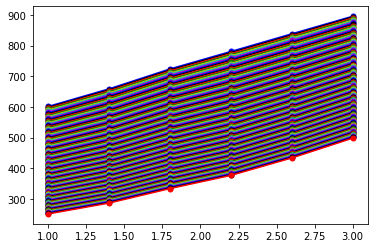

In [29]:
time_list = [1.0, 1.4, 1.8, 2.2, 2.6, 3]#, 3.4, 3.8]
time_arr = make_array(time_list)
velocity_list = list()

for row in range(0, len(chosen_temps)):
    m = return_slope(time_arr, test_arr[row, :8])
    velocity_list.append(m)
    #print('The velocity in angstroms per nanosecond is: {}'.format(m))
    print(m)
    plt.plot(time_list, test_arr[row, :8], marker = 'o', ms = 5, color = 'bkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycmbkrgycm'[row])

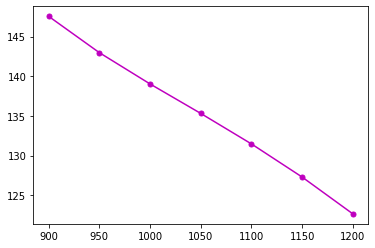

In [23]:
plt.plot(chosen_temps, velocity_list, marker = 'o', ms = 5, color = 'bkrgycmbkrgycmbkrgycm'[row])